In [1]:
import pandas as pd
from IPython.core.display import HTML
from IPython.core.display import Image 
%load_ext music21.ipython21.ipExtension
import numpy as np
import music21 as mu
import pymongo
%pylab inline
from pymongo import MongoClient
from bs4 import BeautifulSoup
import re
import pydash as py_
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)
import math
import music21 as mu
from functools import partial

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)


Populating the interactive namespace from numpy and matplotlib


In [2]:
muAutumnLeaves = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJAutumnLeaves1996_1371_192.xml')
muStellaByStarlight = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJStellaByStarlight1983_1534_161.xml')
muGroovinHigh = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJGroovinHigh1999_1996_290.xml')
muAllTheThingsYouAre = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJAllTheThingsYouAre1983_2143_290.xml')
muIfIWereABell = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJIfIWereABell2002_2161_227.xml')

<h2>Data Preparation</h2>

In [3]:
df = pd.read_pickle('data_set_as_pk.pkl')

<h4><a id="microphrase">Commonly used patterns within phrases</a></h4>

<div>issue that at soe level there is no repeitiion, but this is not the whole story..looking at parts of prhases, there is repetitions. Notes commonly lead to other notes, there, are if particular phrases are not identical, this suggests that parts of phrases are identical finds that there is a great deal o repetition</div>
<div>The first questions would be, in any phrase what are the biggest microphrase? Is key important?</div>
<br>
<div>THere are 3 critical piece of infomation for these musical praes, the frequency of the note, the duration of the note and the position of the note. Do somethings always happen on a certain beat</div>
<div>Looking at patterns of differnet sizes, find whre the repetiions are occuring, is repetion happening because of differnt key, is it driven regaless of rhythm, if we don't take rhythm into account, does this lots or repetition. How is repetition occuring actually taking place here? THe other as pect to take into account is meter. Do things tend to happen more on the beat of the bar. We are looking at phrase in a certain way, so not where there is tiny break</div>

<h5> Two note phrases</h5>

<div>2 note phrases first what is happening....</div>

In [4]:
def titleAsString(data_row):
    titleAsString = str(data_row[0][0:1][0])
    locationAsString = str(data_row[0][1:2][0])
    return titleAsString + ', measure: ' + locationAsString

def concatenatePhrase(x, data_row):
    phraseString = ''
    startingIndexForNoteDetails = x[1]
    endingIndexForNoteDetails = x[2]
    
    for i in range(0, x[0]):
        phraseString = phraseString + str(data_row[i][startingIndexForNoteDetails:endingIndexForNoteDetails])

    return phraseString

def flagIfNoFrequency(x, data_row):
    flag = 0
    for i in range(0, x):
        if np.isnan(data_row[i][2]):
            flag = 1
    return flag

In [5]:
class CreateDataFramesForTwoNotePhraseAnalysis:
    def __init__(self, dataFrame="", numberOfNotesInPhrase = -1):
        self.df = dataFrame
        self.microPhraseArray = -1
        self.twoNotePhrases = -1
        self.startValueToIncludeFrequencyInPhrase = 2
        self.startValueToExludeFrequency = 3
        self.endValueToExcludeRelativeFrequency = 4
        self.endValueToIncludeAllNoteDetails = 5
        self.numberOfNotesInPhrase = numberOfNotesInPhrase

    def createDataFrames(self):
        dfForPhrasePatterns = self.df[self.df['part'] == 'P1'][['title','measure', 'midiNumber', 'quarterNoteDuration', 'nextNoteFreqDistance', 'noteEventStartingLocation', 'Location in measure']]
        listOfNotes = dfForPhrasePatterns.values.tolist()
        microPhraseLength = self.numberOfNotesInPhrase
        microPhraseArray = []
        microPhrase = []
        for x in range(0, len(listOfNotes)):
            counter = 0
            while(counter < microPhraseLength):
                try:
                    val = listOfNotes[x + counter]
                except:
                    pass
                microPhrase.append(val)
                counter = counter + 1
            microPhraseArray.append(microPhrase)
            microPhrase = []
            
        self.twoNotePhrases = pd.DataFrame(microPhraseArray)

        self.twoNotePhrases['Title and location'] = self.twoNotePhrases.apply(titleAsString, axis=1)
        self.twoNotePhrases['Phrase with absolute frequency and duration'] = self.twoNotePhrases.apply(partial(concatenatePhrase, (self.numberOfNotesInPhrase, self.startValueToIncludeFrequencyInPhrase, self.endValueToIncludeAllNoteDetails)), axis=1)
        self.twoNotePhrases['Phrase with relative frequency and duration'] = self.twoNotePhrases.apply(partial(concatenatePhrase, (self.numberOfNotesInPhrase, self.startValueToExludeFrequency, self.endValueToIncludeAllNoteDetails)), axis=1)
        self.twoNotePhrases['Phrase with absolute frequency only'] = self.twoNotePhrases.apply(partial(concatenatePhrase, (self.numberOfNotesInPhrase, self.startValueToIncludeFrequencyInPhrase,self.startValueToExludeFrequency)), axis=1)
        self.twoNotePhrases['Phrase with duration only'] = self.twoNotePhrases.apply(partial(concatenatePhrase, (self.numberOfNotesInPhrase, self.startValueToExludeFrequency, self.endValueToExcludeRelativeFrequency)), axis=1)
        self.twoNotePhrases['Phrase with relative frequency only'] = self.twoNotePhrases.apply(partial(concatenatePhrase, (self.numberOfNotesInPhrase, self.endValueToExcludeRelativeFrequency, self.endValueToIncludeAllNoteDetails)), axis=1)
        self.twoNotePhrases['No Frequency'] = self.twoNotePhrases.apply(partial(flagIfNoFrequency, self.numberOfNotesInPhrase), axis=1)

    def removeGhostPhrasesAndUnneededColumns(self):
        self.twoNotePhrases = self.twoNotePhrases[self.twoNotePhrases['No Frequency'] == 0]
        for i in range(0, self.numberOfNotesInPhrase):
            del self.twoNotePhrases[i]
        del self.twoNotePhrases['No Frequency']

    def returnDataFramesForAnalysis(self):
        #print self.twoNotePhrases
        return self.twoNotePhrases


In [6]:
createTwoNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 2)
createTwoNotePhraseData.createDataFrames()
createTwoNotePhraseData.removeGhostPhrasesAndUnneededColumns()
twoNotephrases = createTwoNotePhraseData.returnDataFramesForAnalysis()

createThreeNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 3)
createThreeNotePhraseData.createDataFrames()
createThreeNotePhraseData.removeGhostPhrasesAndUnneededColumns()
threeNotephrases = createThreeNotePhraseData.returnDataFramesForAnalysis()

createFourNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 4)
createFourNotePhraseData.createDataFrames()
createFourNotePhraseData.removeGhostPhrasesAndUnneededColumns()
fourNotephrases = createFourNotePhraseData.returnDataFramesForAnalysis()

createFiveNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 5)
createFiveNotePhraseData.createDataFrames()
createFiveNotePhraseData.removeGhostPhrasesAndUnneededColumns()
fiveNotephrases = createFiveNotePhraseData.returnDataFramesForAnalysis()

createSixNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 6)
createSixNotePhraseData.createDataFrames()
createSixNotePhraseData.removeGhostPhrasesAndUnneededColumns()
sixNotephrases = createSixNotePhraseData.returnDataFramesForAnalysis()

createSevenNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 7)
createSevenNotePhraseData.createDataFrames()
createSevenNotePhraseData.removeGhostPhrasesAndUnneededColumns()
sevenNotephrases = createSevenNotePhraseData.returnDataFramesForAnalysis()

createEightNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 8)
createEightNotePhraseData.createDataFrames()
createEightNotePhraseData.removeGhostPhrasesAndUnneededColumns()
eightNotephrases = createEightNotePhraseData.returnDataFramesForAnalysis()

createNineNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 9)
createNineNotePhraseData.createDataFrames()
createNineNotePhraseData.removeGhostPhrasesAndUnneededColumns()
nineNotephrases = createNineNotePhraseData.returnDataFramesForAnalysis()

createTenNotePhraseData = CreateDataFramesForTwoNotePhraseAnalysis(df, 10)
createTenNotePhraseData.createDataFrames()
createTenNotePhraseData.removeGhostPhrasesAndUnneededColumns()
tenNotephrases = createTenNotePhraseData.returnDataFramesForAnalysis()


In [8]:
arrayOfPhraseData = [twoNotephrases, threeNotephrases, fourNotephrases, fiveNotephrases, sixNotephrases, sevenNotephrases, eightNotephrases, nineNotephrases, tenNotephrases]

<div>We are trying to find out where there is repetition. And we can ask about repetition in diffent ways</div>

In [37]:
arrayOne = []
arrayTwo = []
arrayThree = []
arrayFour = []
arrayFive = []
for x in range(0, len(arrayOfPhraseData)):
    arrayOne.append(arrayOfPhraseData[x]['Phrase with absolute frequency and duration'].value_counts()[0])
    arrayTwo.append(arrayOfPhraseData[x]['Phrase with relative frequency and duration'].value_counts()[0])
    arrayThree.append(arrayOfPhraseData[x]['Phrase with absolute frequency only'].value_counts()[0])
    arrayFour.append(arrayOfPhraseData[x]['Phrase with relative frequency only'].value_counts()[0])
    arrayFive.append(arrayOfPhraseData[x]['Phrase with duration only'].value_counts()[0])

In [42]:
test = pd.DataFrame({'Highest incidence of phrases with the same absolute frequency and duration':arrayOne, 
                     'Highest incidence of phrases with the same relative Frequency and duration': arrayTwo,
                      'Highest incidence of phrases with the same absolute frequency': arrayThree,
                      'Highest incidence of phrases with the same relative frequency': arrayFour})

In [43]:
arrayOne

[25, 11, 6, 3, 3, 3, 2, 2, 1]

<div>We are looking the top amoutn of repetition here</div>

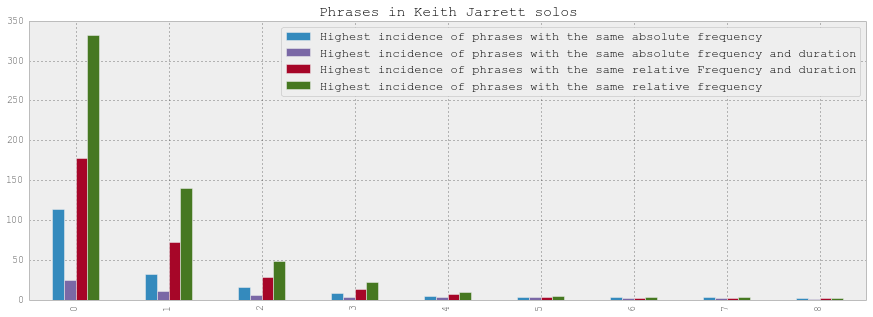

In [44]:
test.plot(kind ="bar", title="Phrases in Keith Jarrett solos")

In [45]:
test['Highest incidence of phrases with the same durations'] =  arrayFive

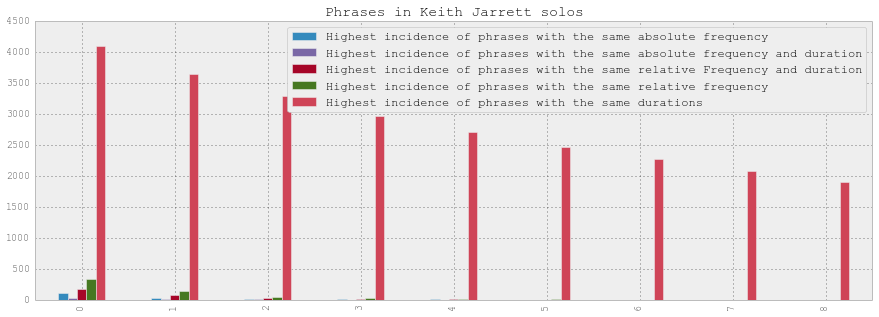

In [46]:
test.plot(kind ="bar", title="Phrases in Keith Jarrett solos")

<div>So what about some actual examples</div>

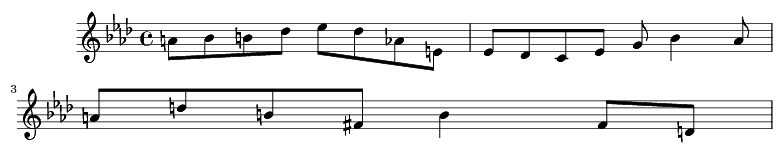

In [163]:
select = muAllTheThingsYouAre.parts[0].measures(32,34)
select.show()

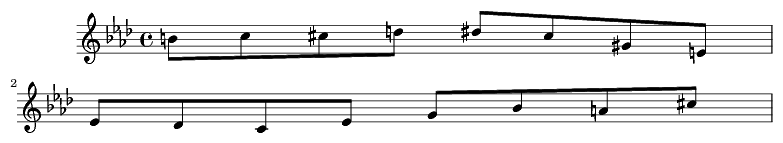

In [164]:
select = muAllTheThingsYouAre.parts[0].measures(68,69)
select.show()

In [130]:
test = pd.DataFrame(phrases['Phrase with absolute frequency and duration'].value_counts())
test['Phrase Details'] = test.index
test['Value counts'] = test[0]
test = test.reset_index(drop = True)
del test[0]

In [165]:
test

Title and location  Phrase with relative frequency and duration  Phrase with absolute frequency only  Phrase with duration only  Phrase with relative frequency only
Phrase with absolute frequency and duration                                                                                                                                                                             
[37.0, 0.25, 1.0][38.0, 0.25, 3.0][41.0, 0.25, ...                   1                                            1                                    1                          1                                    1
[37.0, 0.25, 2.0][39.0, 0.25, -2.0][37.0, 0.25,...                   1                                            1                                    1                          1                                    1
[38.0, 0.25, 3.0][41.0, 0.25, 4.0][45.0, 0.25, ...                   1                                            1                                    1                          1                                    1
[38.0, 0.33, 1.0][39.0, 0.33, -3.0][36.0, 0.33,...                   1                                            1                                    1                          1                                    1
[39.0, 0.25, -2.0][37.0, 0.25, 1.0][38.0, 0.25,...                   1                                            1                                    1                          1                                    1
[39.0, 0.5, -2.0][37.0, 0.25, 2.0][39.0, 0.25, ...                   1                                            1                                    1                          1                                    1
[39.0, 0.5, 9.0][48.0, 0.5, -3.0][45.0, 0.5, 1.0]                    1                                            1                                    1                          1                                    1
[40.0, 0.33, -2.0][38.0, 0.33, 1.0][39.0, 0.33,...                   1                                            1                                    1                          1                                    1
[41.0, 0.25, 1.0][42.0, 0.25, 1.0][43.0, 0.25, ...                   1                                            1                                    1                          1                                    1
[41.0, 0.25, 10.0][51.0, 0.25, -7.0][44.0, 0.25...                   1                                            1                                    1                          1                                    1
[41.0, 0.25, 4.0][45.0, 0.25, 3.0][48.0, 0.33, ...                   1                                            1                                    1                          1                                    1
[41.0, 0.33, -1.0][40.0, 0.33, -2.0][38.0, 0.33...                   1                                            1                                    1                          1                                    1
[41.0, 0.33, -2.0][39.0, 0.5, -2.0][37.0, 0.25,...                   1                                            1                                    1                          1                                    1
[41.0, 0.33, 5.0][46.0, 0.33, 4.0][50.0, 0.33, ...                   1                                            1                                    1                          1                                    1
[41.0, 0.5, 14.0][55.0, 0.5, -4.0][51.0, 0.5, 1.0]                   1                                            1                                    1                          1                                    1
[41.0, 0.5, 3.0][44.0, 0.5, 7.0][51.0, 1.0, -1.0]                    1                                            1                                    1                          1                                    1
[42.0, 0.25, -1.0][41.0, 0.25, 10.0][51.0, 0.25...                   1                                            1                               

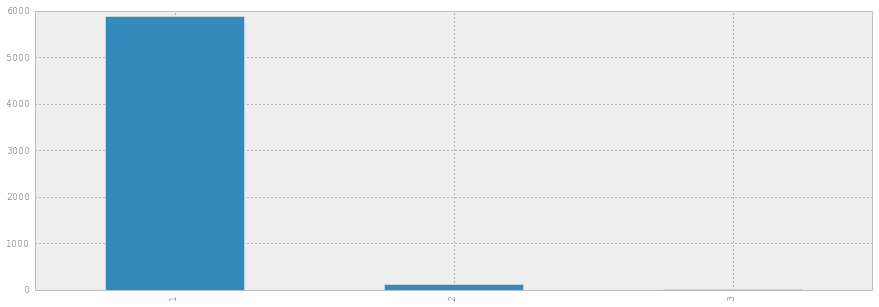

In [133]:
test['Value counts'].value_counts().plot(kind="bar")

In [107]:
test.values

array([[ '[55.0, 0.5, 3.0][58.0, 0.5, 4.0][62.0, 0.5, 3.0][65.0, 0.5, -3.0][62.0, 0.5, 1.0]',
        3],
       [ '[62.0, 0.5, 3.0][65.0, 0.5, 4.0][69.0, 0.5, 3.0][72.0, 0.5, -3.0][69.0, 0.5, 1.0]',
        3],
       [ '[68.0, 0.5, -1.0][67.0, 0.5, -1.0][66.0, 0.5, -1.0][65.0, 0.5, -1.0][64.0, 0.5, -1.0]',
        3],
       ..., 
       [ '[64.0, 0.19, 3.0][67.0, 0.19, -3.0][64.0, 0.19, -4.0][60.0, 0.19, -3.0][57.0, 0.2, 6.0]',
        1],
       [ '[39.0, 0.5, -2.0][37.0, 0.25, 2.0][39.0, 0.25, -2.0][37.0, 0.25, 1.0][38.0, 0.25, 3.0]',
        1],
       [ '[55.0, 0.5, -1.0][54.0, 0.5, -4.0][50.0, 0.5, 3.0][53.0, 0.5, -2.0][51.0, 0.5, 1.0]',
        1]], dtype=object)

In [20]:
allTwoNotePhrases[allTwoNotePhrases['Value Counts'] < 2].count()

Phrase          3158
Value Counts    3158
dtype: int64

In [21]:
3158.0 / 4295

0.7352735739231665

In [22]:
len(twoNotePhrases['Phrase'].value_counts()[1200:])

3095

<div>The first thing it reveal is that things tend not to happen very often. There are are 4295 unquie two note combinations, this looks at any frequency folowwed by any other frequence, any duration followed by another duration. So at this level there is queit a lot of variation. hwoever over 3158 of these only occur once. Means that 75% of the 2 note phrases are actually unique. So there is lots of invention going on here it would mke more sense to look at particular songs, if the correlation to key holds</div>

In [23]:
stellaTwoNotePhrases = phrasesOfVariableLengths[phrasesOfVariableLengths['Title and location'].str.contains('Stell')]['Phrase'].value_counts()

In [24]:
stellaTwoNotePhrases = pd.DataFrame(stellaTwoNotePhrases)

In [25]:
stellaTwoNotePhrases['Phrase'] = stellaTwoNotePhrases.index
stellaTwoNotePhrases['Value counts'] = stellaTwoNotePhrases[0]
stellaTwoNotePhrases = stellaTwoNotePhrases.reset_index(drop = True)

In [26]:
stellaTwoNotePhrases['Value counts'].count()

1001

In [27]:
stellaTwoNotePhrases[stellaTwoNotePhrases['Value counts'] < 2][0].count() 

840

<div>This changes to 84%, whcih means there is not much variation. It suggests that perhaps the issue is mroe about something else, igure frequency </div>

<div>As oppsed a very large amount of variation, here is a different story - so this means that key is not that important for Jarrett - there ends up being lots or repetiions - Jarrett does not tend to do idiomatic things, bu</div>

In [34]:
#repeat function to ignore frequency
def titleAsString(data_row):
    titleAsString = str(data_row[0][0:1][0])
    locationAsString = str(data_row[0][1:2][0])
    return titleAsString + ', measure: ' + locationAsString

def concatenatePhrase(data_row):
    #print len(phrasesOfVariableLengths.columns)
    a = data_row[0][2:3]
    b = data_row[1][2:3]
#     c = data_row[2][2:5]
#     d = data_row[3][2:5]
    return str(a) + str(b)

phrasesOfVariableLengths['Title and location'] = phrasesOfVariableLengths.apply(titleAsString, axis=1)
phrasesOfVariableLengths['Phrase'] = phrasesOfVariableLengths.apply(concatenatePhrase, axis=1)

In [35]:
twoNotePhrasesJustFrequency = pd.DataFrame(phrasesOfVariableLengths['Phrase'].value_counts())
twoNotePhrasesJustFrequency['Phrase'] = twoNotePhrasesJustFrequency.index
twoNotePhrasesJustFrequency['Value counts'] = twoNotePhrasesJustFrequency[0]
twoNotePhrasesJustFrequency = twoNotePhrasesJustFrequency.reset_index(drop = True)

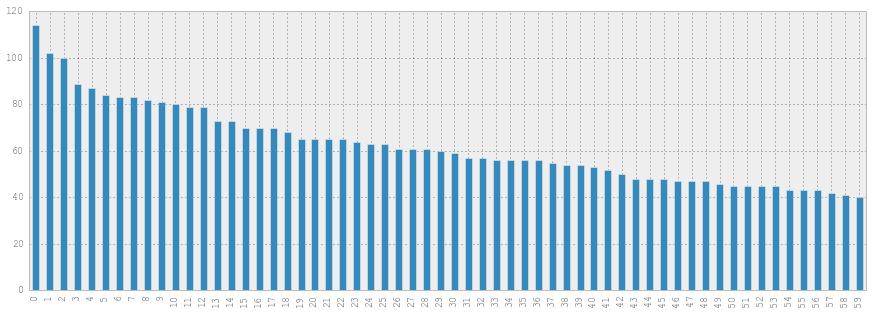

In [36]:
twoNotePhrasesJustFrequency['Value counts'][0:60].plot(kind="bar")

<div>So it appears the combination of rhtym and frequency - two note rhythm patterns are common, two note frequency, but ability to interchange these things is key - Jarrets; ability to use both these variables to extremes</div>

<div>Wo what about for different types of patterns, 7 note patterns</div>

In [44]:
note0 = mu.note.Note("F5")
note0.duration.type = 'half'
note1 = mu.note.Note("C4")
note1.duration.type = 'eighth'
note2 = mu.note.Note("F#4")

streamOne = mu.stream.Stream()
streamOne.append(note0)
streamOne.append(note1)
streamOne.append(note2)

In [45]:
#streamOne.show()

<h5> Two note phrases</h5>

<h5> Three note phrases</h5>

<h5> Four note phrases</h5>

<h5> Five note phrases</h5>

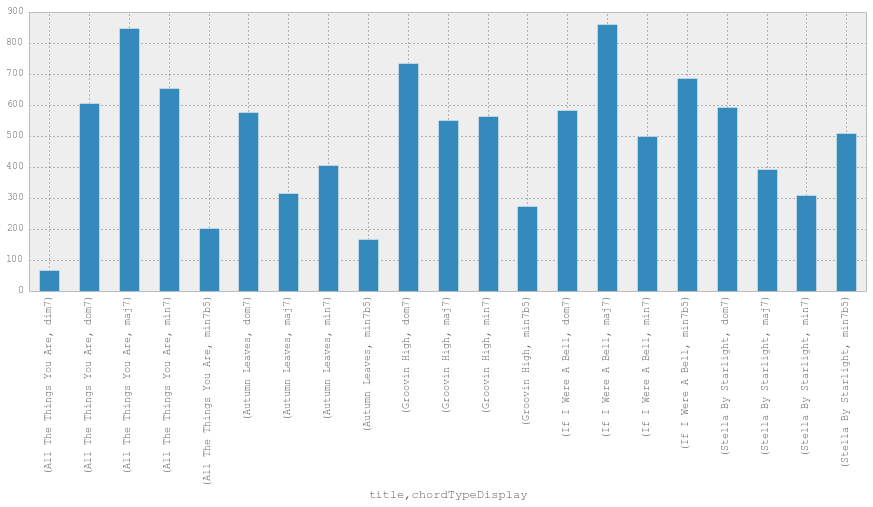

In [412]:
df.groupby(['title', 'chordTypeDisplay'])['chordTypeDisplay'].count().plot(kind="bar")

<div>The first thing we might ask is to keep key relvant. what is the most common figure that might be found</div>

<h4><a id="keySignature">The influence of key signature</a></h4>

<h4><a id="repetitionAndSequences">Repetition and sequences</a></h4>

<h4><a id="rhythm">The use of rhythm</a></h4>

<h4><a id="contour">Melodic contours</a></h4>

<h4><a id="tempo">The influence of tempo</a></h4>

<h4><a id="timeSignaure">The influence of time signature</a></h4>

<h4><a id="songLocation">How melodic phrases are affected by the place they occur</a></h4>